In [241]:
%matplotlib inline
# these two lines allow you to control the figure size
# %pylab inline
# pylab.rcParams['figure.figsize'] = (2.0, 2.0)
import numpy as np
import pandas
from IPython.display import Image as display
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import scipy.misc
import scipy.io
from scipy.stats import multivariate_normal
import seaborn
DOT = np.dot
T = np.transpose
import pickle
import math
import random 
import  scipy.stats as stat

In [242]:
# Set the number of polygons that we're going to have
poly_n = 3
#poly_n = 3

(150, 2)


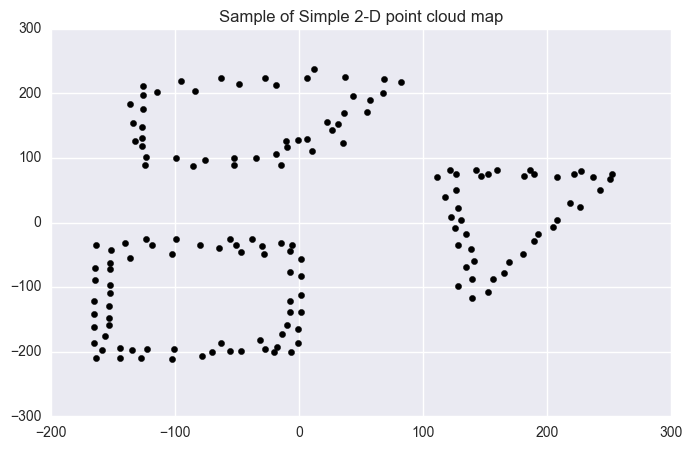

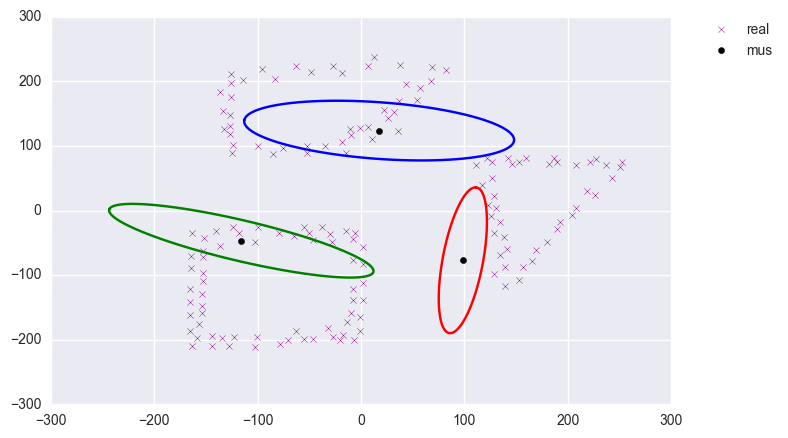

In [251]:

colors = ["red", "blue", "green", "orange", "purple", "pink", "black", 
          "lightblue", "lightgreen","navy", "gray"]



def getPointsInCluster(cluster_weights, t = 0.5):
    cluster = []
    for i in xrange(cluster_weights.shape[0]):
        point = data[i, :]
        weight = cluster_weights[i]
        if weight > t:
            cluster.append(point)
    return np.asarray(cluster)

   
def plot_it(ax, c_w, row, col, title):
    clusters = []
    
    for n in xrange(poly_n):
        ax[row,col].scatter(mus[n][0], mus[n][1], marker="o", s=100)
        ax[row,col].plot(sigma[n][0]+mus[n][0], sigma[n][1]+mus[n][1],c=colors[n])
        
        clusters.append( getPointsInCluster(c_w[:,n:n+1], t = 0.5))
        if len(clusters[n] > 0):
            ax[row,col].scatter(clusters[n][:,0], clusters[n][:,1], color=colors[n],marker='x',
                    label='cluster ' + str(n + 1))
    ax[row,col].title.set_text(title)
            
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

with open("points_map_1.dat") as f:
    data = pickle.load(f)

data = np.array(data)
data = np.reshape(data,(2, data.shape[1])).T

print data.shape
POINTS = data.shape[0]

data = data - data.mean(axis = 0)

def getmus(poly_n):
    r = 125
    points = []
    for index in range(poly_n):
        points.append([r*math.cos((index*2*math.pi)/poly_n + r),r*math.sin((index*2*math.pi)/poly_n + r)])
    return points


mus = np.asarray(getmus(poly_n))
plt.scatter(data[:,0], data[:,1], color='black', marker='o',
            label='real')
plt.title("Sample of Simple 2-D point cloud map")
plt.show()


plt.scatter(data[:,0], data[:,1], color='purple', marker='x',
            label='real')



plt.scatter(mus[:,0], mus[:,1], color='black', marker='o',
            label='mus')
n = 2000

covs = list()
for p in xrange(poly_n):
    x=np.random.normal(size=(2,2))
    y=np.random.normal(size=(2,2))
    z = np.vstack((x, y))
    covs.append(n*np.cov(z.T))
covs = np.asarray(covs)


sigma = []
for n in xrange(poly_n):
    sigma.append(cov_to_pts(covs[n]))
    plt.plot(sigma[n][0]+mus[n][0], sigma[n][1] + mus[n][1],c=colors[n])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# The Gaussian mixing weights
my_randoms = random.sample(xrange(100), poly_n)
mws = [float(my_randoms[i])/sum(my_randoms) for i in xrange(poly_n)]  # called alpha in the slides

## Expectation

In [253]:
#Compute the responsibilities (Eq. 11.27)
def Expectation(covs, mws):
    cluster = []
    sum_to_norm = np.zeros((POINTS,1))
    for n in xrange(poly_n):
        clustern = multivariate_normal.pdf(data, mean=mus[n], cov=covs[n])
        clustern = clustern.reshape((POINTS,1))
        clustern *= mws[n]
        cluster.append(clustern)
        sum_to_norm += clustern
    
    for n in xrange(poly_n):
        cluster[n] = cluster[n] / sum_to_norm
        
    clusters = np.asarray(cluster).T
    clusters = clusters.reshape((POINTS,poly_n))
    
    return clusters
    
        

## Maximization

In [254]:
def Maximization(cluster_w):
    #print "Max cluster_w shape: ",cluster_w.shape
    #print "Cluster, ", cluster_w.shape #(113, 6)
    # combine weights into 1 matrix
    cluster_probs = np.zeros((poly_n, POINTS))
    for n in xrange(poly_n):
        cluster_probs[n] =  cluster_w[:,n]
    cluster_probs = np.transpose(cluster_probs)

    # do the argmax to find out which label is assigned to data point
    # (POINTS, n) composed of 0s and 1s, which cluster it belongs most to
    assigned_labels = cluster_probs.argmax(1)
    assigned_labels = assigned_labels.reshape((POINTS,1))
    
    # Get points for each cluster 
    cluster_points = []
    for n in xrange(poly_n):
        cluster_points.append( data[np.where(assigned_labels == n)[0]])
    
    new_mws = []
    new_mus = []
    new_covs = list()
    for n in xrange(poly_n):
        cluster_N = np.sum(cluster_w[:,n]) #sum all the weights within a cluster
        # New mws ======================
        new_mws.append(cluster_N/float(data.shape[0]))
        
        # New sigma =====================
        # using original mus 
        mu = T(mus[n,:].reshape(2,1))
        
        sig_sum = np.zeros((2,2))
        
        sig_sum = DOT(T(data - mu), (data - mu) * cluster_w[:,n].reshape((POINTS,1))) # DOT ( T(x - mu1), (x - mu1) )
        
        new_sig = sig_sum / cluster_N
        new_covs.append(new_sig)
        
        new_mu = DOT(T(cluster_w[:,n:n+1]),data) / cluster_N
        new_mus.append(new_mu)
    
    new_mus = np.asarray(new_mus)
    
    new_mus = new_mus.reshape((poly_n,2))
    # ================================
    
    return new_mws, new_mus, new_covs, cluster_points



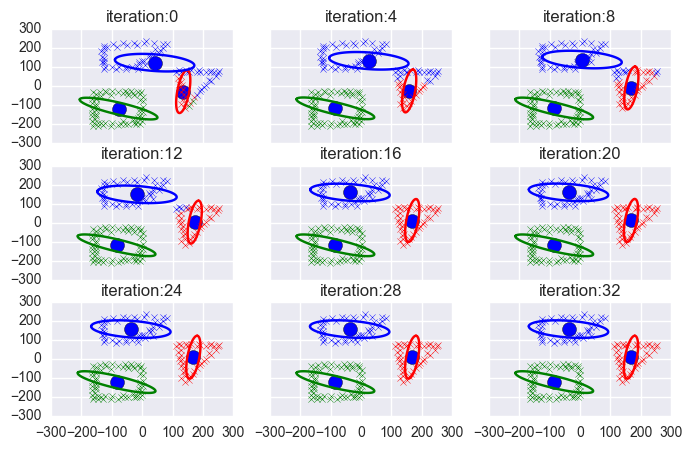

In [255]:
x = -1
l = -1
plt.rcParams['figure.figsize'] = 8, 5
fig, ax = plt.subplots(3,3, sharex = True, sharey = True)
plt.subplots_adjust( wspace = .2, hspace = .2)
for i in xrange(34):
    c_w = Expectation(covs, mws)
    mws, mus, covs, cluster_points = Maximization(c_w) 
    if i % 4 == 0:
        l+=1
        y = l % 3
        if y == 0:
            x+=1
        plot_it(ax, c_w, x, y, "iteration:"+str(i))
        
        

fig.show()

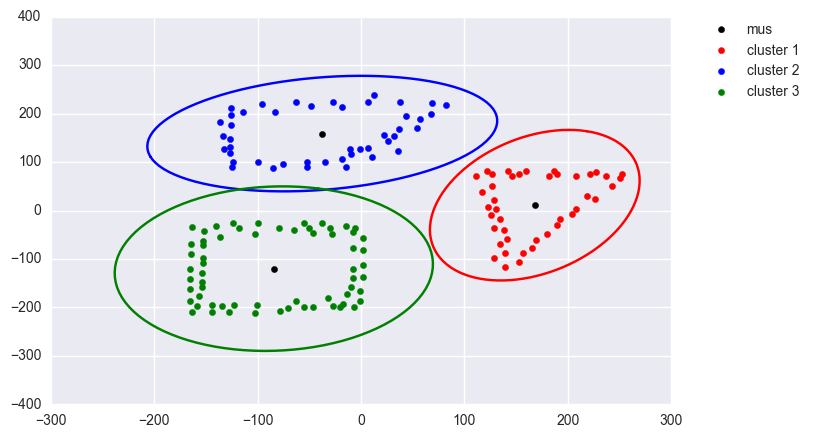

In [256]:


# plt.scatter(data[:,0], data[:,1], color='purple', marker='x',
#             label='real')

plt.scatter(mus[:,0], mus[:,1], color='black', marker='o',
            label='mus')

clusters = []
sigma = []
for n in xrange(poly_n):
    sigma.append(cov_to_pts(covs[n]))
    plt.plot(sigma[n][0]+mus[n][0], sigma[n][1]+mus[n][1],c=colors[n])
    
    clusters.append( getPointsInCluster(c_w[:,n:n+1]))
    if len(clusters[n]) > 0:
        plt.scatter(clusters[n][:,0], clusters[n][:,1], color=colors[n],marker='o',
                label='cluster ' + str(n + 1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [154]:
with open("points_per_polygon.dat", "wb") as f:
    pickle.dump(clusters, f)

In [22]:
with open("points_per_polygon.dat") as f:
    data = pickle.load(f)
    


In [25]:
print data[1].shape

(44, 2)


In [191]:
def chunks(max_x, n):
    skew = max_x * 2
    part = skew/float(n) 
    parts = []
    i = 0
    while i < skew:
        parts.append((i - max_x, min(skew, i+part) - max_x))
        i += part
    return parts


def dist_slopes(max_x, num_slopes):
    chunk_list = chunks(max_x, num_slopes)
    print chunk_list
    slope_list = []
    for a,b in chunk_list:
        slope_list.append(random.uniform(a,b))
    return slope_list 

print dist_slopes(20, 10)

part: 4.0
[(-20, -16.0), (-16.0, -12.0), (-12.0, -8.0), (-8.0, -4.0), (-4.0, 0.0), (0.0, 4.0), (4.0, 8.0), (8.0, 12.0), (12.0, 16.0), (16.0, 20)]
[-16.610680340608194, -14.975940117003148, -11.720611815583794, -7.7966749271790565, -3.5655741173072175, 3.547155916663859, 7.568441406733715, 9.677627096751628, 13.378824471676594, 17.580483463209926]
